### Output directory
`/content/run_20251229_112218`

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

`generation_config` default values have been modified to match model-specific defaults: {'top_k': 20, 'top_p': 0.95, 'pad_token_id': 151643, 'bos_token_id': 151643, 'eos_token_id': [151645, 151643]}. If this is not desired, please set these values explicitly.


## THINKING (raw)

<think>
<brainstorm>
Spider dragline silk is renowned for its exceptional toughness, surpassing many synthetic fibers like Kevlar and steel in energy absorption per unit mass. Key players: beta-sheet nanocrystals (ordered crystalline regions), amorphous regions (disordered, flexible chains), and hierarchical structure (nanoscale to macroscale). Hypotheses: toughness arises from synergistic energy dissipation mechanisms—beta-sheets provide high strength via hydrogen bonding networks, amorphous regions enable extensibility and viscoelasticity, and hierarchical organization distributes stress, prevents crack propagation. Interactions: beta-sheets act as load-bearing nanocrystals that slide or rearrange under stress, dissipating energy; amorphous regions absorb energy through chain slippage and unfolding; hierarchical structure (e.g., nanocrystals embedded in amorphous matrix) allows strain localization without catastrophic failure. Variables: protein composition (e.g., glycine-rich amorph

## FINAL OUTPUT (raw)

Spider dragline silk, produced by orb-weaving spiders like Nephila clavipes, exhibits extraordinary mechanical toughness, defined as the energy absorbed per unit volume before failure, typically exceeding 150 MJ/m³—far surpassing steel (100-150 MJ/m³) and Kevlar (30-40 MJ/m³). This performance is rooted in its hierarchical molecular architecture, where beta-sheet nanocrystals, amorphous protein regions, and a multiscale structure collaborate to dissipate energy efficiently while maintaining high strength and extensibility. The graph of interactions captures this synergy: protein chains self-assemble into beta-sheets stabilized by hydrogen bonds, forming rigid nanocrystals (1-2 nm in size, 10-20 nm in length), while glycine-rich amorphous regions provide flexibility. Hierarchical organization embeds these nanocrystals within the amorphous matrix, creating a composite-like structure that distributes stress and arrests cracks.

At the molecular level, beta-sheet nanocrystals are the prima

### Graph summary
- Nodes: **16**
- Edges: **17**

### Static graph (PNG/SVG saved)

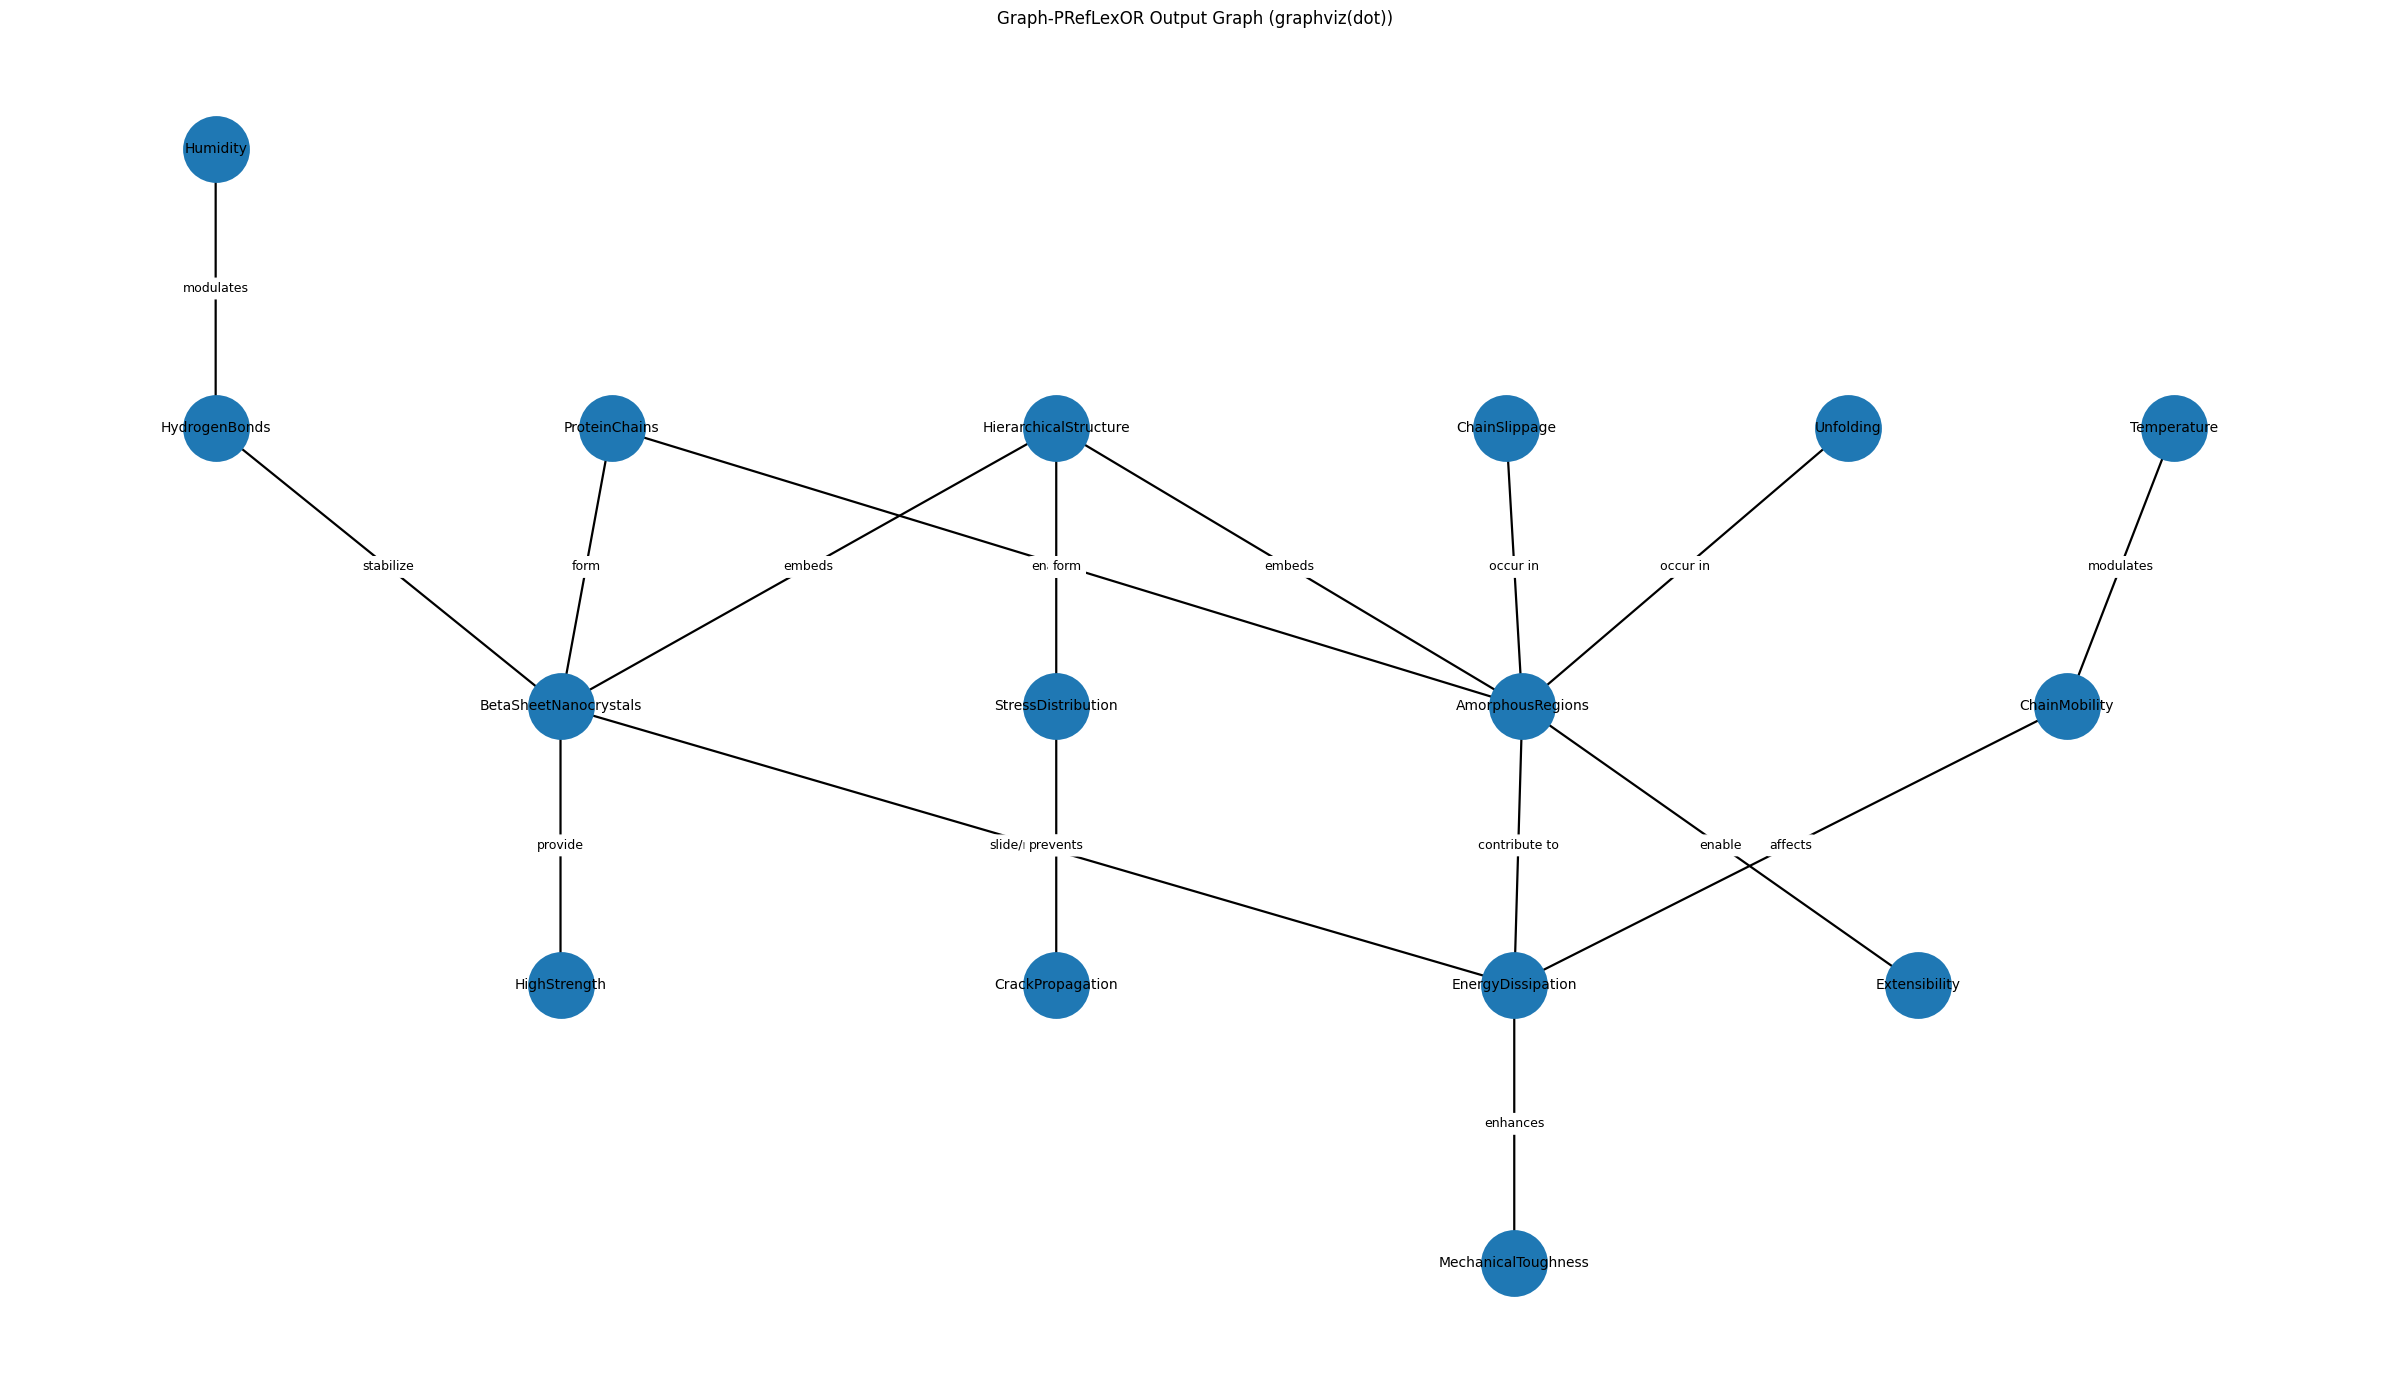

Saved:
- `/content/run_20251229_112218/graph.png`
- `/content/run_20251229_112218/graph.svg`

### Interactive graph (HTML saved)

In [1]:
# ============================================================
# Graph-native reasoning with visualization
# ============================================================

import os
import re
import json
import math
import logging
from datetime import datetime

import torch
import networkx as nx
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

# Interactive graph (Jupyter)
from IPython.display import display, Markdown
import ipywidgets as widgets

# Try PyVis for interactive HTML visualization (recommended)
PYVIS_AVAILABLE = True
try:
    from pyvis.network import Network
except Exception:
    PYVIS_AVAILABLE = False

# ----------------------------
# Run directory + logging
# ----------------------------

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
OUT_DIR = os.path.abspath(f"./run_{RUN_ID}")
os.makedirs(OUT_DIR, exist_ok=True)

LOG_PATH = os.path.join(OUT_DIR, "run.log")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.FileHandler(LOG_PATH), logging.StreamHandler()],
)
log = logging.getLogger("graph-preflexor")

display(Markdown(f"### Output directory\n`{OUT_DIR}`"))

# ----------------------------
# Configuration
# ----------------------------

# token = "hf_..."  # optional
token = None

MODEL_NAME = "lamm-mit/Graph-Preflexor-8b_12292025"
PROMPT = (
    "What are the molecular mechanisms underlying the extraordinary toughness of spider dragline silk? "
    "Investigate the role of beta-sheet nanocrystals, amorphous regions, and hierarchical structure in "
    "energy dissipation and mechanical performance."
)

MAX_NEW_TOKENS = 32_768
THINK_END_TOKEN_ID = 151668  # </think> (model-specific)

DO_SAMPLE = True
GEN_TEMPERATURE = 0.2

GRAPH_JSON_OPEN = "<graph_json>"
GRAPH_JSON_CLOSE = "</graph_json>"

# ----------------------------
# Utility helpers
# ----------------------------

def atomic_write_text(path: str, text: str) -> None:
    """Write text atomically to avoid partial files on crash."""
    tmp = path + ".tmp"
    with open(tmp, "w", encoding="utf-8") as f:
        f.write(text)
    os.replace(tmp, path)

def safe_json_loads(s: str):
    try:
        return json.loads(s)
    except Exception:
        return None

def split_thinking(output_ids, tokenizer, think_end_id):
    """
    Split generated tokens into (thinking, final_content) based on </think>.
    Falls back gracefully if no thinking block is present.
    """
    try:
        split_idx = len(output_ids) - output_ids[::-1].index(think_end_id)
    except ValueError:
        split_idx = 0

    thinking = tokenizer.decode(output_ids[:split_idx], skip_special_tokens=True).strip()
    content  = tokenizer.decode(output_ids[split_idx:], skip_special_tokens=True).strip()
    return thinking, content

def extract_graph_json_block(text: str):
    """
    Extract first <graph_json>...</graph_json> block.
    Returns (raw_json_text, parsed_obj) or (None, None).
    Recovery: locate first '{' and last '}' inside tag block.
    """
    m = re.search(
        rf"{re.escape(GRAPH_JSON_OPEN)}(.*?){re.escape(GRAPH_JSON_CLOSE)}",
        text,
        flags=re.DOTALL
    )
    if not m:
        return None, None

    inner = m.group(1).strip()

    # direct
    obj = safe_json_loads(inner)
    if obj is not None:
        return inner, obj

    # recovery
    i1 = inner.find("{")
    i2 = inner.rfind("}")
    if i1 != -1 and i2 != -1 and i2 > i1:
        candidate = inner[i1:i2+1].strip()
        obj2 = safe_json_loads(candidate)
        if obj2 is not None:
            return candidate, obj2

    return inner, None

def build_nx_graph(graph_obj: dict) -> nx.DiGraph:
    """Build NetworkX DiGraph from {nodes:[{id}], edges:[{source,target,relation}]}."""
    G = nx.DiGraph()

    nodes = graph_obj.get("nodes", [])
    edges = graph_obj.get("edges", [])

    for n in nodes:
        nid = n.get("id")
        if nid:
            attrs = {k: v for k, v in n.items() if k != "id"}
            G.add_node(nid, **attrs)

    for e in edges:
        src = e.get("source")
        tgt = e.get("target")
        if not (src and tgt):
            continue
        rel = e.get("relation", "")
        attrs = {k: v for k, v in e.items() if k not in ("source", "target")}
        attrs["relation"] = rel

        if src not in G:
            G.add_node(src)
        if tgt not in G:
            G.add_node(tgt)

        G.add_edge(src, tgt, **attrs)

    return G

def layout_graph(G: nx.DiGraph):
    """Prefer graphviz dot if available; else spring layout."""
    try:
        from networkx.drawing.nx_pydot import graphviz_layout
        pos = graphviz_layout(G, prog="dot")
        return pos, "graphviz(dot)"
    except Exception:
        pos = nx.spring_layout(G, seed=7, k=0.9)
        return pos, "spring_layout"

def visualize_and_save_static(G: nx.DiGraph, out_dir: str, title: str = "Graph"):
    """Save PNG + SVG with edge labels."""
    png_path = os.path.join(out_dir, "graph.png")
    svg_path = os.path.join(out_dir, "graph.svg")

    if G.number_of_nodes() == 0:
        log.warning("Graph has 0 nodes; skipping static visualization.")
        return None, None

    pos, layout_used = layout_graph(G)
    n = G.number_of_nodes()
    fig_w = min(24, max(12, 0.9 * math.sqrt(n) * 8))
    fig_h = min(14, max(7, 0.6 * math.sqrt(n) * 6))

    plt.figure(figsize=(fig_w, fig_h))
    nx.draw_networkx_nodes(G, pos, node_size=2200, linewidths=1.2)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="-|>", arrowsize=18, width=1.6)
    nx.draw_networkx_labels(G, pos, font_size=10)

    edge_labels = {(u, v): (d.get("relation") or "") for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, rotate=False)

    plt.title(f"{title} ({layout_used})")
    plt.axis("off")
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(svg_path, bbox_inches="tight")
    plt.show()
    plt.close()

    return png_path, svg_path

def visualize_interactive_pyvis(G: nx.DiGraph, out_dir: str, html_name: str = "graph_interactive.html"):
    """
    Create an interactive HTML visualization (PyVis) and display it in the notebook.
    Also saves HTML to disk.
    """
    if not PYVIS_AVAILABLE:
        log.warning("PyVis not available. Install with: pip install pyvis")
        return None

    html_path = os.path.join(out_dir, html_name)

    net = Network(
        height="750px",
        width="100%",
        directed=True,
        bgcolor="#ffffff",
        font_color="#111111",
        notebook=True,
    )

    # Make it less jittery / more readable
    net.barnes_hut(gravity=-20000, central_gravity=0.2, spring_length=150, spring_strength=0.03, damping=0.8)

    # Add nodes
    for n, attrs in G.nodes(data=True):
        title = "<br>".join([f"{k}: {v}" for k, v in attrs.items()]) if attrs else n
        net.add_node(n, label=n, title=title)

    # Add edges with relation labels
    for u, v, attrs in G.edges(data=True):
        rel = attrs.get("relation", "")
        title = "<br>".join([f"{k}: {v}" for k, v in attrs.items()]) if attrs else rel
        net.add_edge(u, v, label=rel, title=title, arrows="to")

    # UI controls
    net.show_buttons(filter_=["physics", "layout", "interaction"])

    net.save_graph(html_path)

    # Display in notebook
    from IPython.display import IFrame
    display(IFrame(src=html_path, width="100%", height=800))

    return html_path

# ----------------------------
# Generation
# ----------------------------

try:
    log.info(f"Output dir: {OUT_DIR}")
    log.info(f"Model: {MODEL_NAME}")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=token)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype="auto",
        device_map="auto",
        token=token,
    )
    model.eval()

    messages = [{"role": "user", "content": PROMPT}]
    prompt_text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=True,
    )

    # Save prompt and rendered template for reproducibility
    atomic_write_text(os.path.join(OUT_DIR, "prompt.txt"), PROMPT)
    atomic_write_text(os.path.join(OUT_DIR, "prompt_rendered.txt"), prompt_text)

    model_inputs = tokenizer(prompt_text, return_tensors="pt").to(model.device)

    gen_config = GenerationConfig(
        max_new_tokens=MAX_NEW_TOKENS,
        do_sample=DO_SAMPLE,
        temperature=GEN_TEMPERATURE,
    )

    log.info("Generating...")
    with torch.no_grad():
        generated = model.generate(**model_inputs, generation_config=gen_config)

    output_ids = generated[0, model_inputs.input_ids.shape[1]:].tolist()
    thinking, content = split_thinking(output_ids, tokenizer, THINK_END_TOKEN_ID)

    # Save ALL text outputs (no truncation)
    atomic_write_text(os.path.join(OUT_DIR, "thinking.txt"), thinking or "")
    atomic_write_text(os.path.join(OUT_DIR, "content.txt"), content or "")
    atomic_write_text(os.path.join(OUT_DIR, "full_output.txt"), (thinking + "\n\n" + content).strip())

    # Show raw thinking and raw final output in the notebook (no truncation)
    display(Markdown("## THINKING (raw)"))
    print(thinking if thinking else "[no thinking content detected]")

    display(Markdown("## FINAL OUTPUT (raw)"))
    print(content if content else "[no final content detected]")

    # ----------------------------
    # Extract graph_json + build graph
    # ----------------------------

    full_text = (thinking + "\n" + content).strip()

    raw_block, graph_obj = extract_graph_json_block(full_text)

    if raw_block is None:
        display(Markdown("### Graph extraction\nNo `<graph_json>...</graph_json>` block found."))
        log.warning("No <graph_json> block found.")
    else:
        atomic_write_text(os.path.join(OUT_DIR, "graph_json_raw.txt"), raw_block)

        if graph_obj is None:
            display(Markdown("### Graph extraction\nFound `<graph_json>` block, but JSON parsing failed. Saved raw block to disk."))
            log.warning("Found <graph_json> but JSON parsing failed.")
        else:
            atomic_write_text(os.path.join(OUT_DIR, "graph.json"), json.dumps(graph_obj, indent=2, ensure_ascii=False))

            G = build_nx_graph(graph_obj)

            display(Markdown(f"### Graph summary\n- Nodes: **{G.number_of_nodes()}**\n- Edges: **{G.number_of_edges()}**"))
            if G.number_of_nodes() > 0:
                display(Markdown("### Static graph (PNG/SVG saved)"))
                png_path, svg_path = visualize_and_save_static(G, OUT_DIR, title="Graph-PRefLexOR Output Graph")

                if png_path and svg_path:
                    display(Markdown(f"Saved:\n- `{png_path}`\n- `{svg_path}`"))

                display(Markdown("### Interactive graph (HTML saved)"))
                html_path = visualize_interactive_pyvis(G, OUT_DIR, html_name="graph_interactive.html")
                if html_path:
                    display(Markdown(f"Saved:\n- `{html_path}`"))
            else:
                display(Markdown("Graph is empty; nothing to visualize."))

except Exception as e:
    # Hard fail-safe: log + crash marker
    log.exception(f"Fatal error: {e}")
    try:
        atomic_write_text(os.path.join(OUT_DIR, "CRASH.txt"), str(e))
    except Exception:
        pass
    raise
